# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import scipy
import math

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [3]:
AAcount = {}
total_AAcount = {}
p = {}

# 10 degrees bins from -180 to 180
bins = [str(x) for x in range(-180, 190, 10)]

# combinations of phi and psi bins
all_phi_psi = []
for x in bins:
    for y in bins:
        all_phi_psi.append('%s %s' % (x.rjust(4), y.rjust(4)))

# the Dunbrack rotamer library
libfile = 'data/overlap_exchangeability_correlation/ALL.bbdep.rotamers.lib'
for line in open(libfile).readlines():
    line = line.rstrip()
    # skip comments
    if line[0] != '#':
        # read the AA and r_1 state
        AA_name = line[:3]
        r_1 = line[25]
        chi_1_rotastate = AA_name + r_1
        # create a dict, set total counts to 0
        if chi_1_rotastate not in AAcount:
            AAcount[chi_1_rotastate] = {y: 0.0 for y in all_phi_psi}
            total_AAcount[chi_1_rotastate] = 0.0
        # read phi, psi
        phi_psi = line[5:14]
        # Counts (observed) * probability (according to library)
        count = float(line[37:45])
        prob = float(line[15:20])
        AAcount[chi_1_rotastate][phi_psi] += count*prob
        total_AAcount[chi_1_rotastate] += count*prob

for chi_1_rotastate in AAcount:
    p[chi_1_rotastate] = {}
    for phi_psi in AAcount[chi_1_rotastate]:
        # Counts for a phi_psi given bin / total count for rotastate
        # masures how likely it is to observe phi/psi values in these 
        # bins for this rotastate
        p[chi_1_rotastate][phi_psi] = AAcount[chi_1_rotastate][phi_psi] / \
            total_AAcount[chi_1_rotastate]

overlap_data = []
for rotastate_1 in AAcount:
    for rotastate_2 in AAcount:
        overlap = 0.0
        for phi_psi in AAcount[rotastate_1]:
            # how different are the probability distributions across
            # all bins for this pair of rotastates? 
            # 1 -> identical ; < 1 -> non identical 
            overlap += min(p[rotastate_1][phi_psi], p[rotastate_2][phi_psi])
        overlap_data.append([rotastate_1, rotastate_2, overlap])
overlap_df = pd.DataFrame(overlap_data, columns=[
                          "rota_1", "rota_2", "overlap"])

In [4]:
RES_3=['ALA','CYS','ASP','GLU','PHE','GLY','HIS','ILE','LYS','LEU','MET','ASN','PRO','GLN','ARG','SER','THR','VAL','TRP','TYR']
RES_1=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
O_TO_3 = {RES_1[x]:RES_3[x] for x in range(20)}
T_TO_1 = {RES_3[x]:RES_1[x] for x in range(20)}

NEW_ORDER = 'PCMILVFWYHRKQNDEST'#GA deleted
NEW_ORDER = 'PCMILVFWYHRKQEDNST'#GA deleted
new_numbers = [2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
ones_to_pick = []
for x in NEW_ORDER:
	if x == 'P':
		for y in range(1,3):
			ones_to_pick.append('%s%i'%(O_TO_3[x],y))
	else:
		for y in range(1,4):
			ones_to_pick.append('%s%i'%(O_TO_3[x],y))

ID_to_index = {ones_to_pick[x]:x for x in range(53)}
o_matrix = np.zeros((53,53))
for l in overlap_df.values:
	if (l[0] in ones_to_pick) and (l[1] in ones_to_pick):
		o_matrix[ID_to_index[l[0]],ID_to_index[l[1]]] = float(l[2])

# RAM55lax2_exchangeability
f = open('data/overlap_exchangeability_correlation/umbertos_exchangibilities_readable').readlines()
names = f[0].strip().split()
a = np.zeros((55,55,))
a_log  = np.zeros((55,55,))
names = f[0].strip().split()
MAXIMUM = 100000000000000000000.0
for i,x in enumerate(f[1:]):
        first = True
        for j,y in enumerate(x.strip().split()):
                if not first:
                        a[i,j-1] = min([MAXIMUM, float(y)])
                        a[j-1,i] = min([MAXIMUM, float(y)])
                        a_log[i,j-1] = math.log(a[i,j-1])
                        a_log[j-1,i] = math.log(a[j-1,i])
                first = False
OLD_ORDER = 'ARNDCQEGHILKMFPSTWYV'
OLD_NUMBERS = [1,3,3,3,3,3,3,1,3,3,3,3,3,3,2,3,3,3,3,3]
base_indices = []
count = 0
for x in OLD_NUMBERS:
        base_indices.append(count)
        count += x
matric_reordering_indices = []
count = 0
for x in 'GA'+NEW_ORDER:
        for i,y in enumerate(OLD_ORDER):
                if x == y:
                        count += OLD_NUMBERS[i]
                        for j in range(OLD_NUMBERS[i]):
                                matric_reordering_indices.append(base_indices[i]+j)
index = np.array(matric_reordering_indices)
a = a[index,:]
a = a[:,index]
a_log = a_log[index,:]
a_log = a_log[:,index]
a = np.delete(a, (0), axis=0)
a = np.delete(a, (0), axis=0)
a = np.delete(a, (0), axis=1)
a = np.delete(a, (0), axis=1)
a_log = np.delete(a_log, (0), axis=0)
a_log = np.delete(a_log, (0), axis=0)
a_log = np.delete(a_log, (0), axis=1)
a_log = np.delete(a_log, (0), axis=1)

everything = []
everything_logged = []
overlap_listed = []
ftnames = []
for x in range(18):
        for y in range(new_numbers[x]):
                ftnames.append('%s%i'%(O_TO_3[NEW_ORDER[x]],y+1))

cols = ["namea", "nameb", "exchagability", "log_exch","overlap"]
arr = []
for x in range(53):
    for y in range(x):
        row = [ftnames[x],ftnames[y],a[x,y],a_log[x,y],o_matrix[x,y]]
        arr.append(row)
overlap_exch_df = pd.DataFrame(arr, columns=cols)
overlap_exch_df

namea nameb  exchagability  log_exch   overlap
0     PRO2  PRO1     104.083319  4.645192  0.445725
1     CYS1  PRO1       0.158449 -1.842325  0.323457
2     CYS1  PRO2       0.059574 -2.820540  0.195675
3     CYS2  PRO1       0.051465 -2.966856  0.192730
4     CYS2  PRO2       0.027643 -3.588396  0.232338
...    ...   ...            ...       ...       ...
1373  THR3  SER1       1.950294  0.667980  0.204946
1374  THR3  SER2       3.103005  1.132371  0.630371
1375  THR3  SER3      11.703081  2.459852  0.578309
1376  THR3  THR1      12.931517  2.559668  0.192268
1377  THR3  THR2      21.182540  3.053177  0.208775

[1378 rows x 5 columns]

In [5]:
# spearmann_corr vs exch
overlap_exch_df.nameb

0       PRO1
1       PRO1
2       PRO2
3       PRO1
4       PRO2
        ... 
1373    SER1
1374    SER2
1375    SER3
1376    THR1
1377    THR2
Name: nameb, Length: 1378, dtype: object

In [6]:
overlap_exch_df = overlap_exch_df[overlap_exch_df.namea.str[:3] != overlap_exch_df.nameb.str[:3]]
overlap_exch_df["AA_pair"] = overlap_exch_df.namea.str[:3] + \
    "-" + overlap_exch_df.nameb.str[:3]
overlap_log_exch_corr = overlap_exch_df.groupby("AA_pair")[["overlap", "log_exch"]].corr(
    "spearman").xs("overlap", level=1)["log_exch"]
overlap_log_exch_corr.sort_values()

AA_pair
TYR-PRO   -0.771429
GLU-MET   -0.366667
THR-ARG   -0.316667
GLU-CYS   -0.300000
GLN-ARG   -0.300000
             ...   
ASN-HIS    0.883333
VAL-PRO    0.885714
THR-CYS    0.900000
ASP-LEU    0.916667
SER-ASP    0.950000
Name: log_exch, Length: 153, dtype: float64

# Results
Show graphs and stats here

In [30]:
overlap_exch_df[overlap_exch_df.AA_pair == "ASN-LEU"]

namea nameb  exchagability  log_exch   overlap  AA_pair
957   ASN1  LEU1       0.084928 -2.465957  0.454689  ASN-LEU
958   ASN1  LEU2       0.002606 -5.949817  0.100293  ASN-LEU
959   ASN1  LEU3       0.209671 -1.562214  0.296338  ASN-LEU
1001  ASN2  LEU1       0.055857 -2.884964  0.207374  ASN-LEU
1002  ASN2  LEU2       0.099422 -2.308382  0.507585  ASN-LEU
1003  ASN2  LEU3       0.112103 -2.188338  0.433925  ASN-LEU
1046  ASN3  LEU1       0.014307 -4.246975  0.273559  ASN-LEU
1047  ASN3  LEU2       0.054006 -2.918652  0.446649  ASN-LEU
1048  ASN3  LEU3       0.504008 -0.685164  0.755413  ASN-LEU

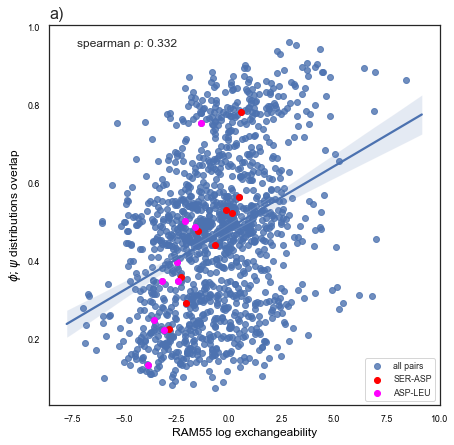

In [38]:
# calc Spearmann's rho
rho, pval = scipy.stats.spearmanr(overlap_exch_df.exchagability,
                                  overlap_exch_df.overlap)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sb.regplot("log_exch", "overlap",
                 data=overlap_exch_df, 
           label="all pairs",
           ax=ax) 

for pair, color in zip(["SER-ASP", "ASP-LEU"], ["red", "magenta"]):
    subset = overlap_exch_df[overlap_exch_df.AA_pair == pair]
    ax.scatter(x=subset.log_exch, y=subset.overlap, 
               label=pair, c=color)
    
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles, labels, loc="lower right");
ax.set_title('a)', loc="left", fontsize=16);     

# add rho, pval
s = f"spearman ρ: {rho:.3f}"
plt.text(0.2, 0.95, s, fontsize=12, ha='center', va='center', transform=ax.transAxes)

ax.set_xlabel("RAM55 log exchangeability",  fontsize=12);
ax.set_ylabel(r"$\phi;\psi$ distributions overlap",  fontsize=12);
#fig.suptitle(
#    r"Correlation between exchangeability and $\phi$;$\psi$ distributions overlap")

fig.savefig("figures/RAM55lax2_overlap_exch_corr_jointplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi);

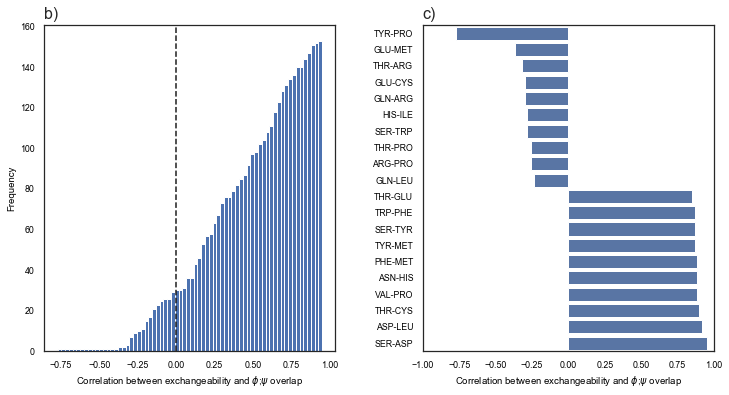

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=.3);

plot_df = overlap_log_exch_corr.sort_values().dropna()
plot_df.hist(bins=70, cumulative=True, color="b", ax=ax1);
ax1.axvline(x=0, linestyle="--", color="k");
ax1.grid(False);


plot_df = pd.concat([plot_df.head(10), plot_df.tail(10)])
sb.barplot(x=plot_df.values, y=plot_df.index, 
                color="b", ax=ax2);
ax2.set_xlim(left=-1, right=1);

ax1.set_ylabel("Frequency");
ax1.set_xlabel("Correlation between exchangeability and $\phi$;$\psi$ overlap");
ax2.set_ylabel("");
ax2.set_xlabel("Correlation between exchangeability and $\phi$;$\psi$ overlap");
ax1.set_title('b)', loc="left", fontsize=16);
ax2.set_title('c)', loc="left", fontsize=16);

fig.savefig("figures/RAM55lax2_overlap_exch_corr_cumplot.pdf", format='pdf',
            bbox_inches='tight', dpi=fig.dpi);

In [ ]:
# plot top 5 most anticorrelated families
fig, ax = plt.subplots(1, figsize=(8, 16))
overlap_log_exch_corr.sort_values().plot.barh(ax=ax)
ax.set_ylabel("Amino acid pair")
ax.set_xlabel(
    "Correlation between exchangeability and $\phi$;$\psi$ distributions")
ax.set_yticklabels(ax.get_yticklabels(),
                   rotation="horizontal", fontsize=6, ha="right")
#fig.suptitle(
#    "Correlation between exchangeability and $\phi$;$\psi$ distributions overlap by amino acid pair", 
#    fontsize="x-large");
fig.savefig("figures/RAM55lax2_overlap_exch_corr_by_AApair_barplot.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)